This notebook contains feature processing and training for a baseline logistic regression model, along with the prediction generation. A model is trained both with the original data set and the augmented data set.

In [25]:
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from helpers import *

## Data Loading

In [2]:
# Path to original images
image_path = str(Path.cwd().parent) + "/data/original/images/"

# Loading original images
files = os.listdir(image_path)
n = len(files) 
print("Loading " + str(n) + " images")
imgs = [mpimg.imread(image_path + files[i]) for i in range(n)]

Loading 100 images
satImage_001.png


In [3]:
# Path to groundtruth images
gt_dir = str(Path.cwd().parent) + "/data/original/groundtruth/"
print("Loading " + str(n) + " images")

# Loading groundtruth images
gt_imgs = []
for i in range (n):
    img = mpimg.imread(gt_dir + files[i])
    try:
        gt_imgs.append(img[:,:,0])
    except:
        gt_imgs.append(img)

Loading 100 images
satImage_001.png


In [26]:
# Each patch is 16*16 pixels
patch_size = 16 

# Extracting patches from the images
img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearizing list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [5]:
# Percentage of pixels > 1 required to assign a foreground label to a patch
foreground_threshold = 0.25 

# Extracting features from images
X = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])

# Creating label list
Y = np.asarray([value_to_class(np.mean(gt_patches[i]), foreground_threshold) for i in range(len(gt_patches))])

In [6]:
# Splitting in training and test set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

## Model

In [8]:
# Creating logistic regression model with sklearn
logreg = LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(x_train, y_train)

LogisticRegression(C=100000.0, class_weight='balanced')

In [9]:
# Predicting on test set
y_hat = logreg.predict(x_test)

# Calcualting F1-score for the test set
f1 = f1_score(y_test, y_hat)

print(f'F1-Score: {f1}')

F1-Score: 0.441351888667992


## Predictions

In [10]:
# Path for test images
image_path = str(Path.cwd().parent) + "/data/testing/"

# Loading test images
files = os.listdir(image_path)
n = len(files) 
print("Loading " + str(n) + " images")
imgs = [mpimg.imread(image_path + files[i]) for i in range(n)]

Loading 50 images


In [11]:
# Looping over test images and creating prediction mask
for i in range(len(imgs)):
    # Extracting patches
    img_patches = [img_crop(imgs[i], patch_size, patch_size)]
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])

    # Extracting features for each patch
    X = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])

    # Predicting
    y_pred = logreg.predict(X)

    # Converting predictions to image
    w = 608
    h = 608
    pred = label_to_img(w, h, patch_size, patch_size, y_pred)

    # Saving image
    cv2.imwrite('pred/%s.png'%('test%d'%(i+1)), pred)

In [23]:
# Generating the prediction file for the test set
submission_filename = 'pred.csv'
image_filenames = []
for j in range(1, 51):
    image_filename = 'pred/test%d.png' % j
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, 0.001, *image_filenames)

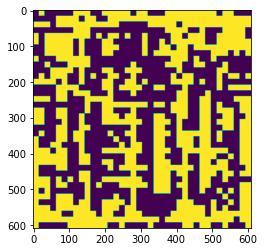

In [18]:
# Inspecting predicted image
img = mpimg.imread('pred/test1.png')
plt.imshow(img)

## Creating New Model With Augmented Training Set

In [13]:
# Path to augmented training set
image_dir = str(Path.cwd().parent) + "/data/training/images/90-split/"

# Loading the images
files = os.listdir(image_dir)
n = len(files) 
imgs = [mpimg.imread(image_dir + files[i]) for i in range(n)]

# Loading the groundtruth images
gt_dir = str(Path.cwd().parent) + "/data/training/groundtruth/90-split/"
gt_imgs = []
for i in range (n):
    img = mpimg.imread(gt_dir + files[i])
    try:
        gt_imgs.append(img[:,:,0])
    except:
        gt_imgs.append(img)

In [14]:
# Extract 16x16 patches from input images
patch_size = 16 

# Extracting patches
img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearizing list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [15]:
# Defining threshold for assigning patch as road
foreground_threshold = 0.25

# Extracting features and labels
X = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i]), foreground_threshold) for i in range(len(gt_patches))])

# Splitting in training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

## Model With Augmented Training Data

In [16]:
# Creating model with sklearn
logreg = LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(x_train, y_train)

LogisticRegression(C=100000.0, class_weight='balanced')

In [17]:
# Predicting on test set
y_hat = logreg.predict(x_test)

# calculating f1-score for test set
f1 = f1_score(y_test, y_hat)

print(f'F1-Score: {f1}')

F1-Score: 0.41968462467858353


We note that the F1-score for the augmented training set is worse than that for the original, and we therefore choose not to evaluate it further.